In [2]:
import itertools
import pathlib

import numpy as np
import pandas as pd
import pint

import matplotlib.pyplot as plt
import matplotlib.colors
import pint
import scipy.stats
import skimage.transform
import pyDOE


ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

## Grid 
We pick a general grid of 256, 256 cells of 10x10 meter. These are constants.

In [3]:
n = {"min": 256, "max": 256, "type": "constant"}
m = {"min": 256, "max": 256, "type": "constant"}
spacing = {"min": 10 * ureg.meter, "max": 10 * ureg.meter, 'type': "constant"}

grid = dict(n=n, m=m, dx=spacing, dy=spacing)
grid

{'n': {'min': 256, 'max': 256, 'type': 'constant'},
 'm': {'min': 256, 'max': 256, 'type': 'constant'},
 'dx': {'min': 10 <Unit('meter')>,
  'max': 10 <Unit('meter')>,
  'type': 'constant'},
 'dy': {'min': 10 <Unit('meter')>,
  'max': 10 <Unit('meter')>,
  'type': 'constant'}}

## Waterlevel
We generate water levels varying from 1 to 50 meters. This is enough for wave lengths of up to 100m (similar to ~700km fetch, 60km/h wind, for 30 hours) to not "feel the bottom". Bathymetries are subtracted from this level. 



In [4]:
water_level = {"$\eta$": {"min": 1 * ureg.meter, "max": 50 * ureg.meter, "type": "uniform"}}

## Waves 
We take a jonswap spectrum where we only vary the modal frequency ($\omega$) and the wave angle ($\theta_{wave}$). We compute $\omega$ based the significant wave height ($\zeta$). 

In [5]:
# TODO: Hm0 (modus significant wave height)
# TODO: Wave Period 
# TODO: check wave steilheid als invoer
# TODO:  check distribution from measurements


# def wave_height_to_omega(wave_height):
#     g = Q_(9.81, 'm/s^2')
#     omega = 0.4 * np.sqrt(g / wave_height)
#     return omega
    
# waves['$\omega$'] = {
#     "min": wave_height_to_omega(waves['$\zeta$']['min']), 
#     "max": wave_height_to_omega(waves['$\zeta$']['max']),
#     "type": "uniform"
# }
waves = {
    "$\zeta$": {"min": Q_(1, ureg.meter),  "max": Q_(20, ureg.meter), "type": "uniform"},
    '$\theta_{wave}$': {"min": Q_(0, ureg.radian), "max": Q_(2 * np.pi, ureg.radian), "type": "circular"}
}

waves


{'$\\zeta$': {'min': 1 <Unit('meter')>,
  'max': 20 <Unit('meter')>,
  'type': 'uniform'},
 '$\theta_{wave}$': {'min': 0 <Unit('radian')>,
  'max': 6.283185307179586 <Unit('radian')>,
  'type': 'circular'}}

## Bathymetry
For the bathymetry we have a collection of bathymetries with varying slope and another collection of random sampled bathymetries of around the world. 

In [20]:
bathy_list = list(pathlib.Path('/').glob('**/*.tif'))

bathymetry = {
    "$bathy_i$": {"min": 0, "max": 1000, "type": "resample"}
}

# "$\theta_{bathy, x,y}$": {"min": Q_(0, 'rad'), "max": Q_(2 * np.pi, 'rad'), "type": "skip"}


In [21]:
parameters = pd.DataFrame(dict(**grid, **waves, **water_level, **bathymetry)).T

In [22]:
parameters

,min,max,type
n,256,256,constant
m,256,256,constant
dx,10 meter,10 meter,constant
dy,10 meter,10 meter,constant
$\zeta$,1 meter,20 meter,uniform
$\theta_{wave}$,0 radian,6.283185307179586 radian,circular
$\eta$,1 meter,50 meter,uniform
$bathy_i$,0,1000,resample


In [23]:
def row_to_N(row):
    min = None
    if isinstance(row['min'], pint.Quantity):
        min = row['min'].m
    else:
        min = row['min']
    if isinstance(row['max'], pint.Quantity):
        max = row['max'].m
    else:
        max = row['max']
    return matplotlib.colors.Normalize(min, max, clip=True)

parameters['N'] = parameters.apply(row_to_N, axis=1)

In [24]:

stochastic = parameters.query('type in ("uniform", "circular", "resample")')
stochastic


n = stochastic.shape[0]
samples = 1000
# take samples from the cube
cube_lhs = pyDOE.lhs(n, samples=samples)


In [25]:
# all boundaries in normalized space
options = [[0, 1] for i in range(n)]
bounds = list(itertools.product(*options))

# do bounds first and then the filled cube
filled_cube = np.r_[bounds, cube_lhs]

In [29]:


samples = {}
for i, (variable, N) in enumerate(stochastic.N.items()):
    normalized_sample = filled_cube[:, i]
    sample = N.inverse(normalized_sample)
    samples[variable] = sample
examples = pd.DataFrame(samples)
examples['$bathy_i$'] = np.int32(examples['$bathy_i$'])
examples['bathy_file'] = 
examples.to_hdf('runs.h5', 'runs')
    
    

In [30]:
examples

,$\zeta$,$\theta_{wave}$,$\eta$,$bathy_i$
0,1.000000,0.000000,1.000000,0
1,1.000000,0.000000,1.000000,1000
2,1.000000,0.000000,50.000000,0
3,1.000000,0.000000,50.000000,1000
4,1.000000,6.283185,1.000000,0
...,...,...,...,...
1011,15.076253,5.781078,6.953107,820
1012,10.418704,2.338672,35.717032,838
1013,2.869270,6.078316,13.406769,137
1014,17.480499,0.195456,18.407262,522


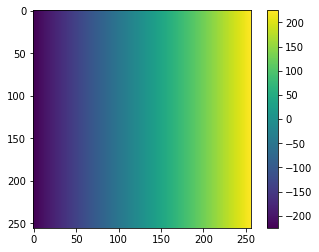

In [34]:


def create_bathy(rot_z, rot_xy=0):
    width = 256
    dx = 10
    hw = int(width / 2)
    op_by_adj = np.tan(np.deg2rad(rot_z))
    height = op_by_adj * np.arange(width * 2) * dx
    z = np.tile(height, [width * 2, 1])
    rotated = skimage.transform.rotate(z, rot_xy)
    center_s = np.s_[hw:2*width-hw, hw:2*width-hw]
    z_rot = rotated[center_s]
    z_rot = z_rot - np.mean(z_rot)
    return z_rot

rot_z = 10
rot_xy = 0
dx = 10

z = create_bathy(rot_z=rot_z, rot_xy=rot_xy)
plt.imshow(z)
plt.colorbar()

In [18]:
np.rad2deg(np.tan(430/2560))

9.715441658128894